In [2]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [3]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

  01 wt_0h 02 wt_2h 03 arm13qd.06_0h 04 arm13qd.06_2h 05 arm13qd.18_0h
1 0.933033 26.17287        0.9308797         23.97291               NA
2 1.064370 24.25147        0.9244497         25.33980               NA
3 1.006956 28.64080        1.1620456         20.44014               NA
4       NA       NA               NA               NA               NA
5 1.016305 26.78463               NA               NA        1.0023132
6 1.044877 24.99094               NA               NA        0.9953897
  06 arm13qd.18_2h 07 flg22_0h 08 flg22_2h   Group
1               NA   0.9953897    78.79324 Trial01
2               NA   0.9885140    88.64701 Trial01
3               NA   1.0163049    82.13926 Trial01
4               NA          NA          NA    <NA>
5         25.10669   1.0352649    76.81591 Trial02
6         25.99208   1.0281138    83.47853 Trial02
# A tibble: 6 × 3
  ind              Group   values
  <chr>            <chr>    <dbl>
1 01 wt_0h         Trial01  0.933
2 02 wt_2h         Trial01

# A tibble: 6 × 3
  Treatment Trial    VALUE
  <chr>     <chr>    <dbl>
1 01 wt_0h  Trial01  0.933
2 01 wt_0h  Trial01  1.06 
3 01 wt_0h  Trial01  1.01 
4 02 wt_2h  Trial01 26.2  
5 02 wt_2h  Trial01 24.3  
6 02 wt_2h  Trial01 28.6  


[1] 36 17

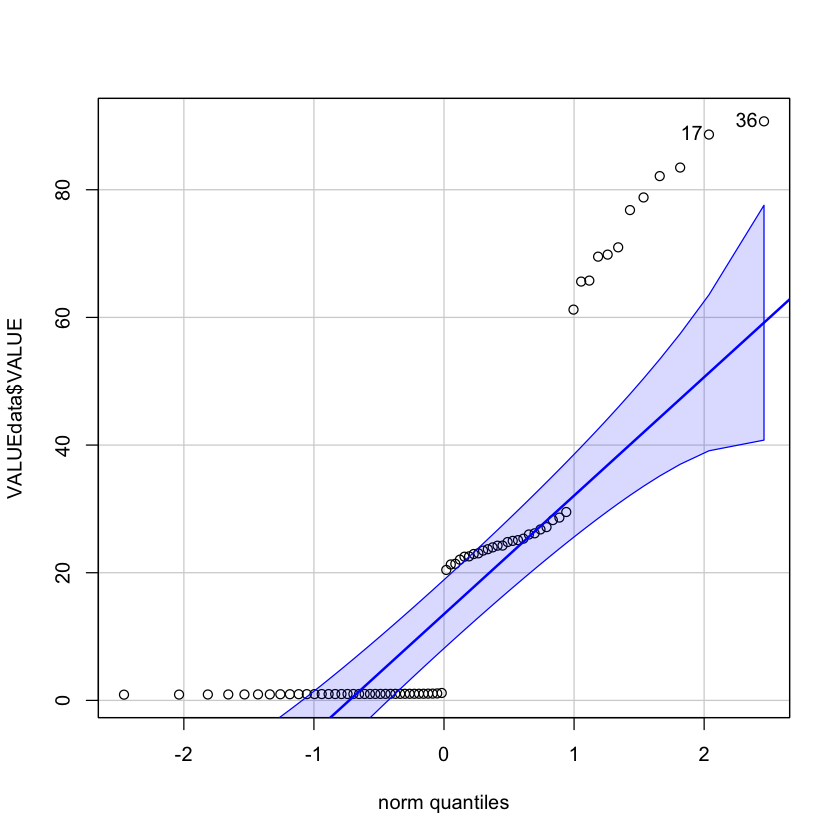

In [4]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   416.1    438.9   -198.1    396.1       62 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3620 -0.3924 -0.0382  0.4607  3.8043 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept)  2.646   1.627   
 Residual             13.187   3.631   
Number of obs: 72, groups:  Trial, 4

Fixed effects:
                           Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)                1.001975   1.326843 16.229947   0.755    0.461    
Treatment02 wt_2h         23.563283   1.482516 67.993884  15.894   <2e-16 ***
Treatment03 arm13qd.06_0h -0.126020   1.868396 70.380185  -0.067    0.946    
Treatment04 arm13qd.06_2h 23.066386   1.868396 70.380185  12.346   <2e-16 ***
Treatment05 arm13qd.18_0h  0.125317   1.868396 70.380185   0.06

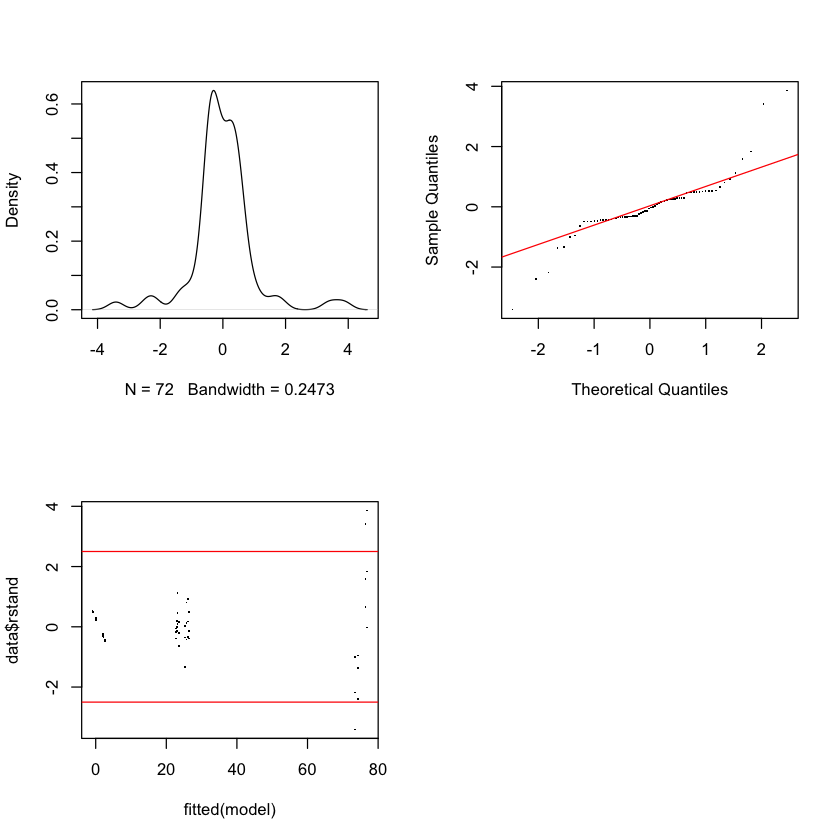

In [5]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [6]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF          F value     
 Min.   :50069   Min.   :7153   Min.   :7   Min.   :68.23   Min.   :542.4  
 1st Qu.:50069   1st Qu.:7153   1st Qu.:7   1st Qu.:68.23   1st Qu.:542.4  
 Median :50069   Median :7153   Median :7   Median :68.23   Median :542.4  
 Mean   :50069   Mean   :7153   Mean   :7   Mean   :68.23   Mean   :542.4  
 3rd Qu.:50069   3rd Qu.:7153   3rd Qu.:7   3rd Qu.:68.23   3rd Qu.:542.4  
 Max.   :50069   Max.   :7153   Max.   :7   Max.   :68.23   Max.   :542.4  
     Pr(>F)         
 Min.   :3.414e-57  
 1st Qu.:3.414e-57  
 Median :3.414e-57  
 Mean   :3.414e-57  
 3rd Qu.:3.414e-57  
 Max.   :3.414e-57  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                           Estimate Std. Error z value Pr(>|z|)
02 wt_2h - 01 wt_0h == 0     